# <center><b>CSCI4050U - Machine Learning Project</b></center>
## <center><i>Fundamentals of Variational Autoencoders</i></center>
<br>
<center>Aleem Alibhai - 100636156</center>
<center>Connor Henderson - 100491403</center>

## Libraries & Imports

In [22]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.datasets as datasets
import tensorflow.keras.utils as utils

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from PIL import Image as image
from PIL import ImageSequence as GIF
import sys
from IPython.display import display, Markdown, Latex


# Data Preprocessing

## Data sourcing

The images and figures presented in the document are sourced from <a href="https://quickdraw.withgoogle.com/data">Google's Quick Draw</a> dataset with the class names provided where relevant.

In [2]:
np.random.seed(0)

def get_samples(label, n_samples):
    return np.load(f"data/{label}.npy")[:n_samples].reshape((-1, 28,28))/255.

def get_train_test_data(labels, n, split):
    samples = np.asarray([get_samples(label, n // len(labels)) for label in labels])
    samples = samples.reshape((n, 28, 28,1))
    np.random.shuffle(samples)
    
    train = samples[:int(len(samples * split))]
    test = samples[int(len(samples * split)):]
    
    return train, test
    
def format_img_for_display(img,cmap=None):
    img = tf.reshape(img, [28, 28])
    img = (cmap(np.asarray(img)) if cmap is not None else np.asarray(img) * 255).astype(np.uint8)
    return img

## Autoencoder

An autoencoder is a type of end-to-end neural network architecture that introduces an information bottleneck. It's composed of three main parts:

1. Encoder 
2. Bottleneck
3. Decoder

The encoder ($ g_\phi $) and decoder ($ f_\theta$) are two separate networks that are trained in tandem. The encoder takes in some input ($x$) and applies a sequence of transformations, decreasing in dimensionality with each layer until it has the same dimensionality as the bottleneck layer. The bottleneck layer ($z$) in an autoencoder, then, can be represented by:
<br><br>
<center>$z = g_\phi(x)$</center>

We can observe the fact that this encoding and subsequent decoding are a deterministic process; the produced embedding is also entirely dependent on the parameters of the encoder network. The decoder takes the low dimensional <i>$z$</i> representation and performs the same process in reverse as the layers increase in size, producing a new input $x'$ such that:

<center>$x' = f_\theta(g_\phi(x))$</center>

By introducing a bottleneck layer, we force the network to discard any information that (ideally) isn't necessary for reconstruction. This comes with the added benefit that the learned representation in the bottleneck has a smaller dimensionality and may have reduced noise which may be helpful for certain downstream machine learning tasks. Putting this all together, we can formulate this as an optimization problem by measuring our loss by the difference in our $x$ and $x'$ vectors, we choose to use <i>Mean Squared Error </i> since we are dealing with real valued numbers for image reconstruction:
<br><br>
<center>$\mathcal{L}_{AE}(\theta,\phi)=\frac{1}{n}\sum^n_{i=1}(x^{(i)}-f_\theta(g_\phi(x^{(i)})))^2$</center>
<br>
<center>$=\frac{1}{n}\sum^n_{i=1}(x^{(i)}-x{' }^{(i)})^2$</center>

## Variational Autoencoders

There are, however, a great deal of limitations in the use of just the reconstruction term for constructing our latent space. Since the network is learning to minimize the reconstruction error in this embedding process, it will favour the combination of weights that maximizes the distances between points. If instead of embedding things <i>deterministically</i>, we introduce the notion of embedding our vectors <i>probabilistically</i>, then we can enforce the constraint that we will sample from a multivariate Gaussian with a diagonal covariance structure [Kingma and Welling, 2014]. More simply, we're going to sample from a normal distribution that's parameterized by a learned mean matrix and a learned variance matrix that form a basis for the latent space. While sampling is typically a stochastic process that would prevent us from backpropagating our error, we can use the reparameterization trick. The reparameterization trick just has us add an auxiliary variable $\epsilon$ (where $\epsilon\sim\mathcal{N}(0,1)$) as part of the encoding step. 

####This means we can now use the following to obtain z:
<br>
<br>
<center>$z = g_\phi(\epsilon, x)$</center>

<img src="https://miro.medium.com/max/2098/1*ZlzFeen0J7Ize__drfbwOQ.png" width=500>
<center><b>Figure #:</b> The reparameterization trick visually explaining how we pass the gradient;</center>
<center>beware the slight difference in notation for $g_\phi$</center>
<br><br>

In [11]:
def reparameterize(z):
    z_mean, z_log_var = z

    std = tf.math.exp(0.5 * z_log_var)
    eps = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], tf.shape(z_mean)[1]))
    return z_mean + std * eps

This method of obtaining z is still deterministic, and thus we can use it to pass our gradients; this means we now have the tools to reformulate our loss function to include regularization. To this end we employ reversed Kullbeck-Leibler Divergence ($D_{KL}$) as a means of measuring the relative difference between our input and the reparameterized sample. By minimizing $D_{KL}$, we are creating a model that is best able to predict the true distribution over our data.
<center>$\mathcal{L}(\theta, \phi; x^{(i)}) = \mathcal{-}D_{KL}(q_\phi(z{\mid}x^{(i)}){\parallel}p_\theta(z)) + \mathbb{E}_{q_{\phi}(z{\mid}x^{(i)})}\bigg[ log p_\theta(x^{(i)}\mid z)\bigg]$</center>

Using the reparameterization to sample the expectation value and the following identity from Appendix Section B from Kingma and Welling, 2014:
<br><br>
<center>$\mathcal{-}D_{KL}(q_\phi(z{\mid}x^{(i)}){\parallel}p_\theta(z)) = \frac{1}{2}\sum^J_{j=1}(1 + log((\sigma_j)^2)=(\mu_j)^2-(\sigma_j)^2)$</center>


We get the final loss function for our network:
<center>$\mathcal{L}_{VAE} = \frac{1}{n}\sum^n_{i=1}(x^{(i)}-x{' }^{(i)})^2 + \frac{1}{2}\sum^J_{j=1}(1 + log((\sigma_j)^2)=(\mu_j)^2-(\sigma_j)^2)$</center>


# Network Architecture

## Encoder

Our encoder is structured to use learned image features to create the latent space. The initial input shape of our image is (28, 28, 1). The image is sequentially fed through two convolution layers, each halving the resolution of the image, resulting in a final dimension of (7, 7, 64). This is then flattened and fed through a fully connected dense layer.
We feed the output of the dense layer to two individual dense layers, each of which are of the same output dimensions as our desired latent space. These dense layers will output the ùúá and ùúé values that are used to construct and sample from a normal distribution. The outputs of the encoder are the $\mu$ and $\sigma$ values from the dense layer as well as a sample ùëß obtained using the reparameterize function.

In [3]:
class Encoder(keras.Model):
    def __init__(self, latent_dim=2, name="encoder"):
        super(Encoder, self).__init__(name=name)
        
        self.latent_dim = latent_dim
        self.conv1 = layers.Conv2D(32, 3, strides=2, name="conv_1", padding="same", activation="relu", input_shape=(28, 28, 1))
        self.conv2 = layers.Conv2D(64, 3, strides=2, name="conv_2", padding="same", activation="relu")
        self.flatten = layers.Flatten()
        self.dense_1 = layers.Dense(16, name="dense_1", activation="relu")

        self.z_mean_layer = layers.Dense(latent_dim, name="z_mean")
        self.z_log_var_layer = layers.Dense(latent_dim, name="z_log_var")

    def call(self, inputs, training = True):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.dense_1(x)

        z_mean = self.z_mean_layer(x)
        z_log_var = self.z_log_var_layer(x)
        
        z = reparameterize([z_mean, z_log_var])
        if training == False:
            z = reparameterize([z_mean, 0])
        
        return [z_mean, z_log_var, z]

## Decoder
Our decoder is essentially the reverse of our encoder; it takes a sample from a given distribution and returns a reconstructed image. The input is fed through a Dense layer with the same shape as the encoder's flatten layer. The inputs are then reshaped to match the output dimensionality of the encoder's convolution layers. The data then goes through two Transpose Convolution layers that increase the resolution of the image from its embedded dimension to the output shape of (28, 28, 1). The result is the reconstructed image from the given sample.

In [4]:
class Decoder(keras.Model):
    def __init__(self, latent_dim=2, name="decoder"):
        super(Decoder, self).__init__(name=name)
        self.latent_dim = latent_dim
        self.in_dense = layers.Dense(7 * 7 * 64, activation="relu", name="input_dense")
        self.reshape = layers.Reshape((7, 7, 64))
        
        self.conv_t_1 = layers.Conv2DTranspose(
            64, 
            3, 
            strides=2, 
            padding="same", 
            name="Transpose_Conv2D_1", 
            activation="relu", 
            input_shape=(7, 7, 64)
        )
        
        self.conv_t_2 = layers.Conv2DTranspose(
            32, 
            3, 
            strides=2, 
            padding="same", 
            name="Transpose_Conv2D_2", 
            activation="relu"
        )
        
        self.output_layer = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
        
    def call(self, inputs):
        x = self.in_dense(inputs)
        x = self.reshape(x)
        x = self.conv_t_1(x)
        x = self.conv_t_2(x)
        x = self.output_layer(x)
        return x    

## Variational Autoencoder
Here we define the VAE model architecture and follow it up with some experiments to highlight the characteristics of a VAE.

In [5]:
class VAE(keras.Model):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
    
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)       
        self.beta = latent_dim
        self.latent_dim = latent_dim
        self.training = True
        
    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        
        return z_mean, z_log_var, z, reconstruction
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.MSE(data, reconstruction), axis=(1, 2)
                )
            )
            
            #kl_loss = tf.math.reduce_mean(- 0.5 * tf.math.reduce_sum(1 - tf.math.exp(z_log_var) - z_mean ** 2 + z_log_var, axis=1), axis=0)
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1), axis=0)
            
            kl_loss = self.beta * kl_loss
            
            total_loss = reconstruction_loss + kl_loss
            
        gradients = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))  
        return {
            "loss": tf.math.reduce_mean(total_loss),
            "kl": tf.math.reduce_mean(kl_loss),
            "mse": tf.math.reduce_mean(reconstruction_loss),
        }

In [10]:
# Get the data
n_samples = 60000
labels = ['mushroom', 'crayon', 'crown', 'cookie', 'face', 'moustache']
train_test_split = 0.80

train_data, test_data = get_train_test_data(labels, n_samples, train_test_split)

# Create the VAE
vae = VAE(latent_dim = 3)

# Perform training
vae.compile(optimizer = optimizers.Adam(1e-4))
vae.fit(train_data, epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 173s 368ms/step - loss: 97.2250 - kl: 0.6745 - mse: 96.5505
Epoch 2/10
469/469 [==============================] - 177s 376ms/step - loss: 72.6067 - kl: 1.0149 - mse: 71.5918
Epoch 3/10
469/469 [==============================] - 182s 387ms/step - loss: 67.6893 - kl: 3.1450 - mse: 64.5443
Epoch 4/10
469/469 [==============================] - 179s 382ms/step - loss: 65.6376 - kl: 4.9648 - mse: 60.6729
Epoch 5/10
469/469 [==============================] - 183s 391ms/step - loss: 64.8030 - kl: 5.8787 - mse: 58.9242
Epoch 6/10
469/469 [==============================] - 182s 389ms/step - loss: 64.2576 - kl: 6.3818 - mse: 57.8759
Epoch 7/10
469/469 [==============================] - 183s 389ms/step - loss: 63.7961 - kl: 6.7078 - mse: 57.0883
Epoch 8/10
469/469 [==============================] - 184s 391ms/step - loss: 63.5632 - kl: 7.0484 - mse: 56.5148
Epoch 9/10
469/469 [==============================] - 183s 390ms/step - loss: 63.3149 - 

## Visual Analysis

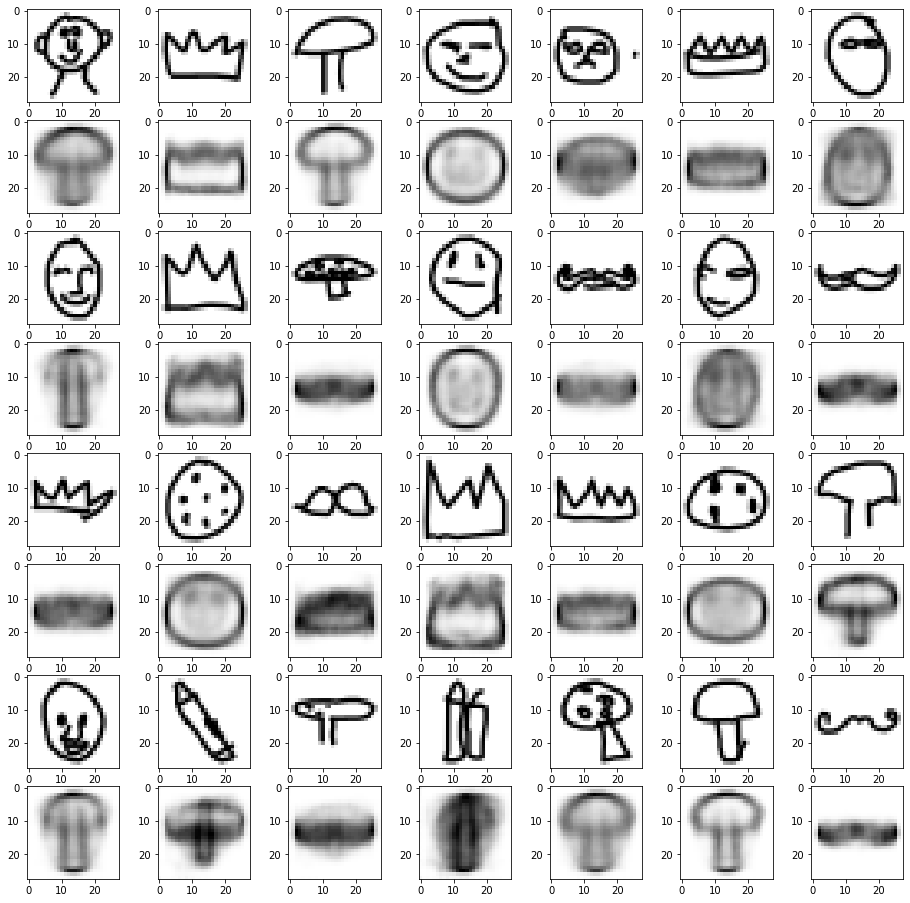

In [17]:
nrow = 8
ncol = 7

plt.figure(figsize=(16,16))
for i in range(nrow // 2):
    for j in range(ncol):
        data = train_data[i * nrow + j]
        data = tf.reshape(data, [28, 28])

        plt.subplot(nrow, ncol, (i * 2) * ncol + (j + 1))
        plt.imshow(data, cmap="binary")
        
    for j in range(ncol):
        data = [train_data[i * nrow + j]]
        data = tf.reshape(data, [1, 28, 28, 1])
        
        z_mean, z_log_var, z = vae.encoder(data)
        reconstruction = vae.decoder(z)
        reconstruction = tf.reshape(reconstruction,[28,28])

        plt.subplot(nrow, ncol, (i * 2 + 1) * ncol + (j + 1))
        plt.imshow(reconstruction, cmap="binary")

<div class="alert alert-block alert-info"><b></b> There are some cookies with faces and some faces with mushrooms, but for small scale reconstructions that's not bad!</div>

## Experiment \# 1: Latent Perturbation

In [9]:
# color scheme:
cm = plt.get_cmap('gist_heat')

def get_latent_space(vae, latent_i = 0, n=6, figsize=15):
        # display a n*n 2D manifold of images
        image_size = 28
        scale = 1.0
        figure = np.zeros((image_size * n, image_size * n))
        # linearly spaced coordinates corresponding to the 2D plot
        # of image classes in the latent space
        grid_x = np.linspace(-scale, scale, n)
        grid_y = np.linspace(-scale, scale, n)[::-1]

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = np.array([[xi, yi, latent_i] + [1 for i in range(vae.latent_dim - 3) ]])


                x_decoded = vae.decoder.predict(z_sample)
                image = x_decoded[0].reshape(image_size, image_size)
                figure[
                    i * image_size : (i + 1) * image_size,
                    j * image_size : (j + 1) * image_size,
                ] = image
        return figure

figures = []

for latent_i in np.linspace(-1, 1, 30):
    print(f"{(latent_i + 1) / 0.02:.4f}% complete", end="\r")
    figure = get_latent_space(vae, n=30, latent_i = latent_i)

    if cm is None:
        cm = plt.get_cmap("binary")

    figure = image.fromarray((cm(figure)[:,:,:3] * 255).astype(np.uint8))

    figures.append(figure)

figures = np.stack(figures)


images = [image.fromarray(figure).convert("RGB") for figure in figures]

images = images + images[::-1]

images[0].save("output.gif", save_all=True, append_images=images[1:], loop=0, duration=100)


<!-- We are very proud of this .gif -->
<img src="https://i.imgur.com/3RuHfmh.gif" width="750" align="center"><br><br>
<center><b>Figure #:</b> Latent Perturbation for <i>mushrooms, crayons, crowns, and cookies.</i> </center>

## Experiment \#2: Interpolation between Classes

<center><b>Figure #</b></center>

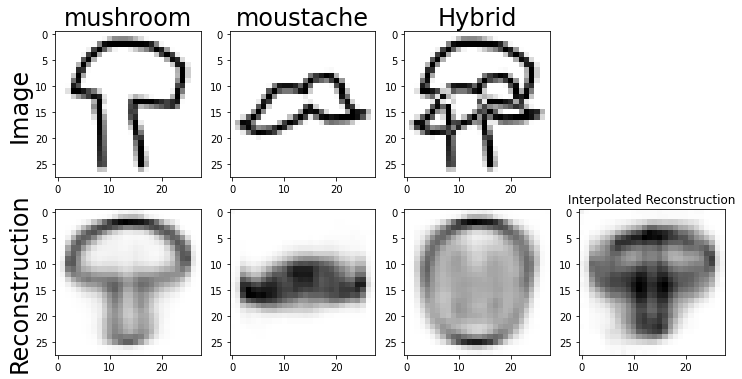

In [58]:
# image choice 1
i = 1
image1_label = 'mushroom'

# imge choice 2
j = 402
image2_label = 'moustache'


# get the moustache 
image1 = get_samples(image1_label, 500)[i]
image1 = tf.reshape(image1, [1, 28, 28, 1])

_, _, embedded_image1 = vae.encoder(image1)
decoded_image1 = vae.decoder(embedded_image1)
decoded_image1 = tf.reshape(decoded_image1, [28, 28, 1])

image2 = get_samples(image2_label, 500)[j]
image2 = tf.reshape(image2, [1, 28,28,1])
_, _, embedded_image2 = vae.encoder(image2)
decoded_image2 = vae.decoder(embedded_image2)
decoded_image2 = tf.reshape(decoded_image2, [28, 28, 1])

hybrid = image2 + image1
_, _, embedded_hybrid = vae.encoder(hybrid)
decoded_hybrid = vae.decoder(embedded_hybrid)
decoded_hybrid = tf.reshape(decoded_hybrid, [28, 28, 1])
hybrid = tf.reshape(hybrid, [28,28,1])

interpolated_image = embedded_image1 + embedded_image2
interpolated_image /= 2
decoded_interp = vae.decoder(interpolated_image)
decoded_interp = tf.reshape(decoded_interp, [28, 28, 1])

plt.figure(figsize=(12,6))
plt.subplot(241)
plt.ylabel("Image", fontsize=24)
plt.title(image1_label, fontsize=24)
plt.imshow(format_img_for_display(image1), cmap='binary')
plt.subplot(242)
plt.title(image2_label, fontsize=24)
plt.imshow(format_img_for_display(image2), cmap='binary')
plt.subplot(243)
plt.title("Hybrid", fontsize=24)
plt.imshow(format_img_for_display(hybrid), cmap='binary')



plt.subplot(245)
plt.ylabel("Reconstruction", fontsize=24)
plt.imshow(format_img_for_display(decoded_image1), cmap='binary')
plt.subplot(246)
plt.imshow(format_img_for_display(decoded_image2), cmap='binary')
plt.subplot(247)
plt.imshow(format_img_for_display(decoded_hybrid), cmap='binary')
plt.subplot(248)
plt.title("Interpolated Reconstruction")
plt.imshow(format_img_for_display(decoded_interp), cmap='binary')
display(Markdown("<center><b>Figure #</b></center>"))

<div class="alert alert-block alert-info"><b></b> Mushroom + Moustache = Human!</div>

## Exploring Datasets

In [24]:
moustaches = get_samples('moustache', 500)
i = 0

359


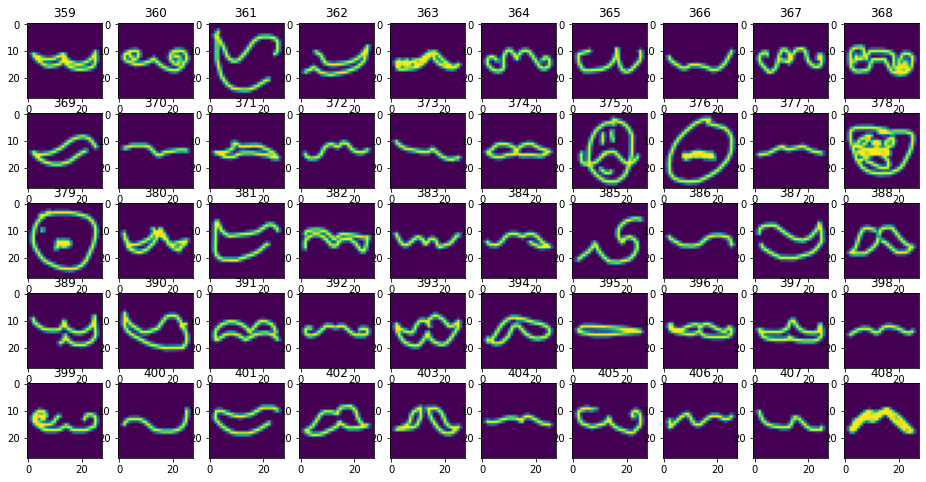

In [41]:
rows = 5
plt.figure(figsize=(16,8))
for j in range(rows * 10):
    plt.subplot(rows,10,j+1)
    plt.title(i + j)
    plt.imshow(format_img_for_display(moustaches[i + j]))
    
print(i)
i += rows * 10

In [34]:
faces = get_samples('face', 500)
x = 0

100


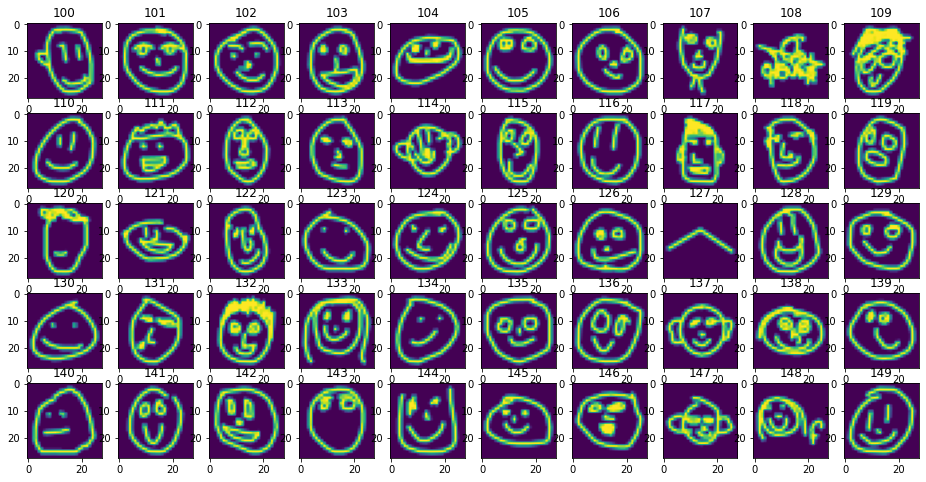

In [40]:
rows = 5
plt.figure(figsize=(16,8))
for y in range(rows * 10):
    plt.subplot(rows,10,y+1)
    plt.title(x + y)
    plt.imshow(format_img_for_display(faces[x + y]))
    
print(x)
x += rows * 10

# Sources

Diederik P Kingma and Max Welling. 2014.  Auto-Encoding Variational Bayes <a href="https://arxiv.org/pdf/1312.6114.pdf">arXiv:1312.6114</a>


Keras Documentation. 2020. Variational AutoEncoder <a href="https://keras.io/examples/generative/vae/">Keras.io</a>

Lilian Weng. 2018. From Autoencoder to Beta-VAE <a href="https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html">lilianweng.github.io</a>